In [15]:
import os
import time
import scipy
import netCDF4
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm

# Constants

In [16]:
date_min = "20230301"
date_max = "20230531"
#
experiment = "v6"
AMSR2_frequency = "18.7"
threshold_water_fraction = 0.5
model_architecture = "GNN"
sizefont = 12
#
paths = {}
paths["predictions"] = "/lustre/storeB/project/nwp/H2O/wp3/Deep_learning_predictions/GNN/Models_static/" + experiment + "/Predictions_" +  AMSR2_frequency.split('.')[0] + "GHz/"
paths["surfex"] = "/lustre/storeB/users/josteinbl/sfx_data/LDAS_NOR/archive/"
paths["output"] = "/lustre/storeB/project/nwp/H2O/wp3/Deep_learning_predictions/GNN/Models_static/" + experiment + "/" + "Scores_" + AMSR2_frequency.split('.')[0] + "GHz/"
#
for var in paths:
    if os.path.isdir(paths[var]) == False:
        os.system("mkdir -p " + paths[var])

# Load data

In [17]:
class load_data_and_concatenate():
    def __init__(self, date_min, date_max, threshold_water_fraction, paths):
        self.date_min = date_min
        self.date_max = date_max
        self.threshold_water_fraction = threshold_water_fraction
        self.paths = paths
    #
    def make_list_dates(self):
        current_date = datetime.datetime.strptime(self.date_min, "%Y%m%d")
        end_date = datetime.datetime.strptime(self.date_max, "%Y%m%d")
        list_dates = []
        while current_date <= end_date:
            date_str = current_date.strftime("%Y%m%d")
            list_dates.append(date_str)
            current_date = current_date + datetime.timedelta(days = 1)
        return(list_dates)
    #
    def load_water_mask(self):
        filename_surfex_constants = self.paths["surfex"] + "2023/01/01/00/SURFOUT.nc"
        with netCDF4.Dataset(filename_surfex_constants, "r") as nc:
            frac_sea = nc.variables["FRAC_SEA"][:,:]
            frac_water = nc.variables["FRAC_WATER"][:,:]
        frac_sea_and_water = frac_sea + frac_water
        frac_sea_and_water[frac_sea_and_water > 1] = 1
        frac_sea_and_water = np.expand_dims(np.flipud(frac_sea_and_water), axis = 0)
        return(frac_sea_and_water)
    #
    def load_predictions(self, date_task, frac_sea_and_water):
        Dataset = {}
        filename = self.paths["predictions"] + date_task[0:4] + "/" + date_task[4:6] + "/" + "Predictions_" + date_task + ".nc"
        with netCDF4.Dataset(filename, "r") as nc:
            for var in nc.variables:
                if var not in ["x", "y", "lat", "lon"]:
                    Dataset[var] = np.expand_dims(nc.variables[var][:,:], axis = 0)
                    Dataset[var][frac_sea_and_water >= self.threshold_water_fraction] = np.nan
        return(Dataset)
    #
    def time_concatenation(self, Dataset, Conc_dataset, date_task):
        if date_task == self.date_min:
            for var in Dataset:
                if var not in  ["x", "y", "lat", "lon"]:
                    Conc_dataset[var] = np.copy(Dataset[var])
        else:
            for var in Conc_dataset:
                Conc_dataset[var] = np.concatenate((Dataset[var], Conc_dataset[var]), axis = 0)
        return(Conc_dataset)

    #
    def __call__(self):
        Conc_dataset = {}
        frac_sea_and_water = self.load_water_mask()
        list_dates = self.make_list_dates()
        for date_task in list_dates:
            print(date_task)
            try:
                Dataset = self.load_predictions(date_task, frac_sea_and_water)
                Conc_dataset = self.time_concatenation(Conc_dataset, Dataset, date_task)
            except:
                pass
        return(Conc_dataset)

# Verification

In [18]:
class verification():
    def __init__(self, Dataset, AMSR2_frequency, paths):
        self.Dataset = Dataset
        self.AMSR2_frequency = AMSR2_frequency
        self.paths = paths
        self.list_targets = ["AMSR2_BT" + self.AMSR2_frequency + "H", "AMSR2_BT" + self.AMSR2_frequency + "V"]
    #
    def spatial_pearson_coefficient(self, array3D_1, array3D_2):
        tdim, ydim, xdim = np.shape(array3D_1)
        pcc = np.full((ydim, xdim), np.nan)
        for i in range(0, ydim):
            for j in range(0, xdim):
                idx_nan = np.logical_or(np.isnan(array3D_1[:,i,j]), np.isnan(array3D_2[:,i,j]))
                valid_array_1 = array3D_1[:, i, j][idx_nan == False]
                valid_array_2 = array3D_2[:, i, j][idx_nan == False]
                if len(valid_array_1) >= 2 and len(valid_array_2) >= 2:  
                    pcc[i,j] = scipy.stats.pearsonr(valid_array_1, valid_array_2)[0]
        return(pcc)
    #
    def temporal_pearson_coefficient(self, array2D_1, array2D_2):
        idx_nan = np.logical_or(np.isnan(array2D_1), np.isnan(array2D_2))
        valid_array_1 = array2D_1[idx_nan == False]
        valid_array_2 = array2D_2[idx_nan == False]
        if len(valid_array_1) >= 2 and len(valid_array_2) >= 2:  
            pcc = scipy.stats.pearsonr(valid_array_1, valid_array_2)[0]
        return(pcc)
    #
    def calculate_spatial_scores(self):
        Spatial_scores = {}
        for var in self.list_targets:
            var_output = var.replace("AMSR2_BT", "BT")
            Errors = self.Dataset["Prediction_" + var] - self.Dataset["Target_" + var]
            Spatial_scores["Bias_" + var_output] = np.nanmean(Errors, axis = 0) 
            Spatial_scores["MAE_" + var_output] = np.nanmean(np.abs(Errors), axis = 0)
            Spatial_scores["RMSE_" + var_output] = np.sqrt(np.nanmean(np.square(Errors), axis = 0))
            Spatial_scores["Pearson_correlation_" + var_output] = self.spatial_pearson_coefficient(self.Dataset["Prediction_" + var], self.Dataset["Target_" + var])      
        return(Spatial_scores)
    #
    def calculate_time_series(self):
        Time_series = {}
        for var in self.list_targets:
            var_output = var.replace("AMSR2_BT", "BT")
            Errors = self.Dataset["Prediction_" + var] - self.Dataset["Target_" + var]
            time_dim = np.shape(Errors)[0]
            Time_series["Bias_" + var_output] = np.full(time_dim, np.nan)
            Time_series["MAE_" + var_output] = np.full(time_dim, np.nan)
            Time_series["RMSE_" + var_output] = np.full(time_dim, np.nan)
            Time_series["Pearson_correlation_" + var_output] = np.full(time_dim, np.nan)
            #
            for ti in range(0, time_dim):
                Time_series["Bias_" + var_output][ti] = np.nanmean(Errors[ti,:,:])
                Time_series["MAE_" + var_output][ti] = np.nanmean(np.abs(Errors[ti,:,:]))
                Time_series["RMSE_" + var_output][ti] = np.sqrt(np.nanmean(np.square(Errors[ti,:,:])))
                Time_series["Pearson_correlation_" + var_output][ti] = self.temporal_pearson_coefficient(self.Dataset["Prediction_" + var][ti,:,:], self.Dataset["Target_" + var][ti,:,:])  
        #
        return(Time_series)    
    #
    def __call__(self):
        Spatial_scores = self.calculate_spatial_scores()
        Time_series = self.calculate_time_series()
        return(Spatial_scores, Time_series) 

# Make figures

In [19]:
def make_figure_spatial_scores(Spatial_scores, AMSR2_frequency, date_min, date_max, model_architecture, experiment, sizefont, paths, saving = False):
    n_channels = 2
    norm_bias = BoundaryNorm(np.linspace(-5, 5, 11), 256)
    norm_error = BoundaryNorm(np.linspace(0, 10, 11), 256)
    norm_correlation = BoundaryNorm(np.linspace(0, 1, 11), 256)
    list_targets = ["BT" + AMSR2_frequency + "H", "BT" + AMSR2_frequency + "V"]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, axs = plt.subplots(n_channels, 4, figsize = (n_channels * 7, 4 * 2), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    plt.suptitle(experiment + "\n" + date_min + " - " + date_max, fontsize = sizefont * 1.5)
    #
    for n_chan, channel in enumerate(list_targets):
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 1)
        im = ax.imshow(Spatial_scores["Bias_" + channel], norm = norm_bias, cmap = "RdBu", aspect = "auto")
        ax.set_title("Bias " + channel, fontsize = sizefont)
        ax.axis("off") 
        cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', pad = 0.03, shrink = 0.9)
        cbar.set_label("Brightness temperature (K)", fontsize = sizefont * 0.8)
        ax.text(0.05, 0.05, "Mean: " + str(round(np.nanmean(Spatial_scores["Bias_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
        #
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 2)
        im = ax.imshow(Spatial_scores["MAE_" + channel], norm = norm_error, cmap = "gnuplot", aspect = "auto")
        ax.set_title("Mean absolute error " + channel, fontsize = sizefont)
        ax.axis("off")
        cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', pad = 0.03, shrink = 0.9)
        cbar.set_label("Brightness temperature (K)", fontsize = sizefont * 0.8)
        ax.text(0.05, 0.05, "Mean: " + str(round(np.nanmean(Spatial_scores["MAE_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
        #
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 3)
        im = ax.imshow(Spatial_scores["RMSE_" + channel], norm = norm_error, cmap = "gnuplot", aspect = "auto")
        ax.set_title("Root mean square error " + channel, fontsize = sizefont)
        ax.axis("off")
        cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', pad = 0.03, shrink = 0.9)
        cbar.set_label("Brightness temperature (K)", fontsize = sizefont * 0.8)
        ax.text(0.05, 0.05, "Mean: " + str(round(np.nanmean(Spatial_scores["RMSE_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
        #
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 4)
        im = ax.imshow(Spatial_scores["Pearson_correlation_" + channel], norm = norm_correlation, cmap = "gnuplot", aspect = "auto")
        ax.set_title("Pearson correlation " + channel, fontsize = sizefont)
        ax.axis("off")
        cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', pad = 0.03, shrink = 0.9)
        cbar.set_label("Correlation coefficient", fontsize = sizefont * 0.8)
        ax.text(0.05, 0.05, "Mean: " + str(round(np.nanmean(Spatial_scores["Pearson_correlation_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
    #
    if saving == True:
        plt.savefig(paths["output"] + "Spatial_scores_" + model_architecture + "_" + experiment + "_" + date_min + "_" + date_max + ".png", dpi = 300, bbox_inches = "tight")
    else:
        plt.show()

In [20]:
def make_figure_time_series(Time_series, AMSR2_frequency, date_min, date_max, model_architecture, experiment, sizefont, paths, saving = False):
    n_channels = 2
    list_targets = ["BT" + AMSR2_frequency + "H", "BT" + AMSR2_frequency + "V"]
    #
    xlabels = ["01-09-22", "01-11-22", "01-01-23", "01-03-23", "01-05-23"]
    xpos = [0, 61, 122, 181, 242]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, axs = plt.subplots(n_channels, 4, figsize = (n_channels * 8, 4 * 2), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.3, wspace = 0.35)
    plt.suptitle(experiment + "\n" + date_min + " - " + date_max, fontsize = sizefont * 1.5)
    #
    for n_chan, channel in enumerate(list_targets):
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 1)
        ax.plot(Time_series["Bias_" + channel], "b")
        ax.set_title("Bias " + channel, fontsize = sizefont) 
        ax.set_ylabel("Brightness temperature (K)", fontsize = sizefont * 0.8)
        ax.set_xticks(xpos, xlabels, rotation = 30, ha = "right", fontsize = sizefont * 0.9)
        ax.text(0.05, 0.90, "Mean: " + str(round(np.nanmean(Time_series["Bias_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
        #
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 2)
        ax.plot(Time_series["MAE_" + channel], "b")
        ax.set_title("Mean absolute error " + channel, fontsize = sizefont) 
        ax.set_ylabel("Brightness temperature (K)", fontsize = sizefont * 0.8)
        ax.set_xticks(xpos, xlabels, rotation = 30, ha = "right", fontsize = sizefont * 0.9)
        ax.text(0.05, 0.90, "Mean: " + str(round(np.nanmean(Time_series["MAE_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
        #
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 3)
        ax.plot(Time_series["RMSE_" + channel], "b")
        ax.set_title("Root mean square error " + channel, fontsize = sizefont) 
        ax.set_ylabel("Brightness temperature (K)", fontsize = sizefont * 0.8)
        ax.set_xticks(xpos, xlabels, rotation = 30, ha = "right", fontsize = sizefont * 0.9)
        ax.text(0.05, 0.90, "Mean: " + str(round(np.nanmean(Time_series["RMSE_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
        #
        ax = plt.subplot(n_channels, 4, n_chan * 4 + 4)
        ax.plot(Time_series["Pearson_correlation_" + channel], "b")
        ax.set_title("Pearson correlation coefficient " + channel, fontsize = sizefont) 
        ax.set_ylabel("Pearson correlation coefficient", fontsize = sizefont * 0.8)
        ax.set_xticks(xpos, xlabels, rotation = 30, ha = "right", fontsize = sizefont * 0.9)
        ax.text(0.05, 0.05, "Mean: " + str(round(np.nanmean(Time_series["Pearson_correlation_" + channel]), 2)), fontsize = sizefont, ha = "left", transform = ax.transAxes)
    #
    if saving == True:
        plt.savefig(paths["output"] + "Time_series_" + model_architecture + "_" + experiment + "_" + date_min + "_" + date_max + ".png", dpi = 300, bbox_inches = "tight")
    else:
        plt.show()


# Data processing

20221201
20221202
20221203
20221204
20221205
20221206
20221207
20221208
20221209
20221210
20221211
20221212
20221213
20221214
20221215
20221216
20221217
20221218
20221219
20221220
20221221
20221222
20221223
20221224
20221225
20221226
20221227
20221228
20221229
20221230
20221231
20230101
20230102
20230103
20230104
20230105
20230106
20230107
20230108
20230109
20230110
20230111
20230112
20230113
20230114
20230115
20230116
20230117
20230118
20230119
20230120
20230121
20230122
20230123
20230124
20230125
20230126
20230127
20230128
20230129
20230130
20230131
20230201
20230202
20230203
20230204
20230205
20230206
20230207
20230208
20230209
20230210
20230211
20230212
20230213
20230214
20230215
20230216
20230217
20230218
20230219
20230220
20230221
20230222
20230223
20230224
20230225
20230226
20230227
20230228


/tmp/ipykernel_851124/3797505940.py:33: RuntimeWarning: Mean of empty slice
  Spatial_scores["Bias_" + var_output] = np.nanmean(Errors, axis = 0)
/tmp/ipykernel_851124/3797505940.py:34: RuntimeWarning: Mean of empty slice
  Spatial_scores["MAE_" + var_output] = np.nanmean(np.abs(Errors), axis = 0)
/tmp/ipykernel_851124/3797505940.py:35: RuntimeWarning: Mean of empty slice
  Spatial_scores["RMSE_" + var_output] = np.sqrt(np.nanmean(np.square(Errors), axis = 0))


Computing time:  81.14894247055054


<Figure size 640x480 with 0 Axes>

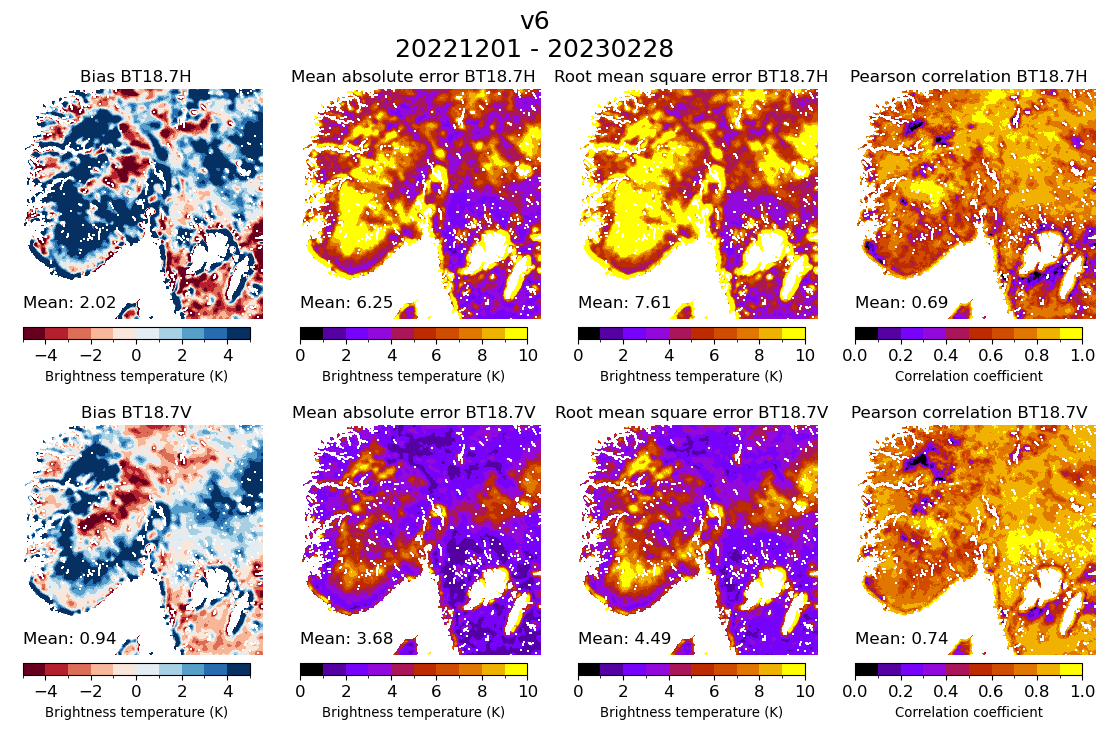

<Figure size 640x480 with 0 Axes>

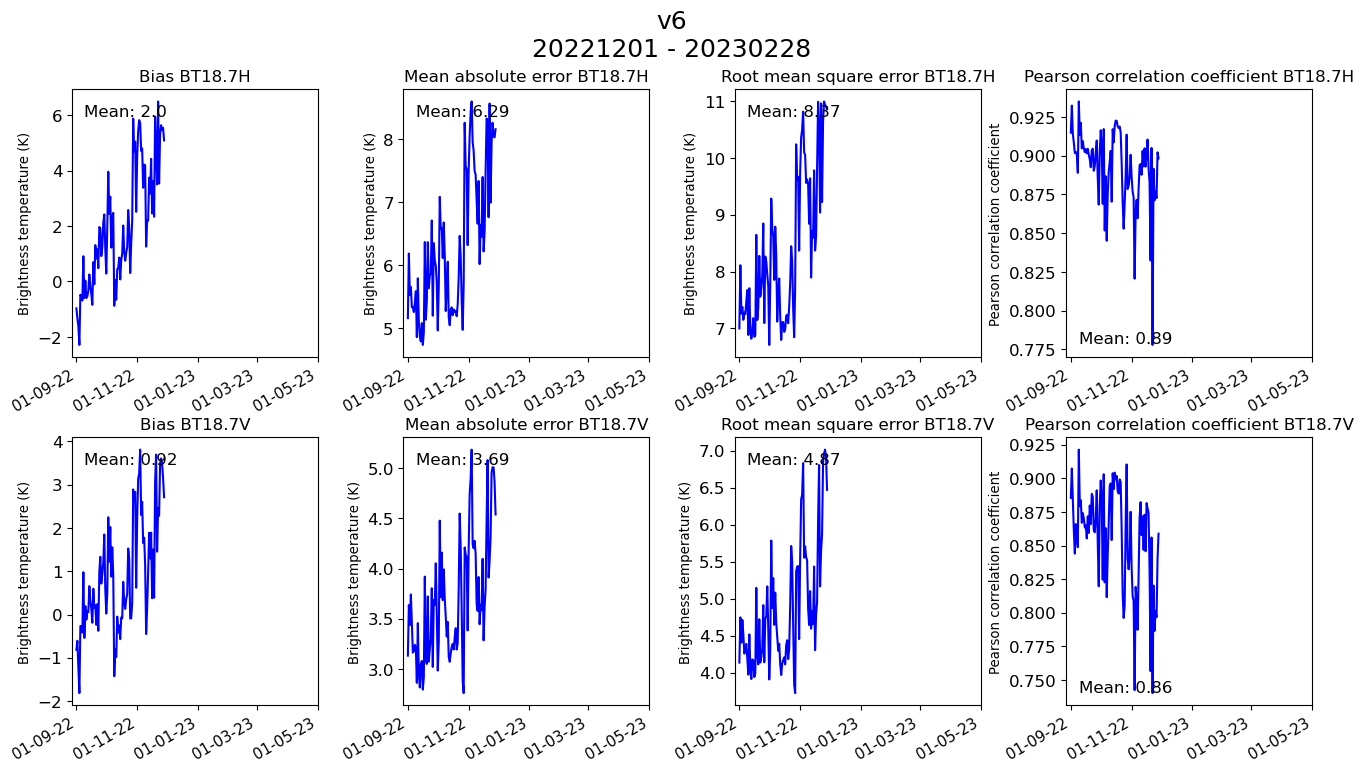

In [21]:
t0 = time.time()
Dataset = load_data_and_concatenate(date_min = date_min, 
                                    date_max = date_max, 
                                    threshold_water_fraction = threshold_water_fraction, 
                                    paths = paths)()
#
Spatial_scores, Time_series = verification(Dataset = Dataset,
                                           AMSR2_frequency = AMSR2_frequency,
                                           paths = paths)()
#
make_figure_spatial_scores(Spatial_scores = Spatial_scores, 
                           AMSR2_frequency = AMSR2_frequency, 
                           date_min = date_min, 
                           date_max = date_max, 
                           model_architecture = model_architecture, 
                           experiment = experiment, 
                           sizefont = sizefont, 
                           paths = paths, 
                           saving = True)
#
make_figure_time_series(Time_series = Time_series, 
                        AMSR2_frequency = AMSR2_frequency, 
                        date_min = date_min, 
                        date_max = date_max, 
                        model_architecture = model_architecture, 
                        experiment = experiment, 
                        sizefont = sizefont, 
                        paths = paths, 
                        saving = True)
#
tf = time.time()
print("Computing time: ", tf - t0)